# Grover's search algorithm
Grover's search algorithm is one of the more straightforward quantum algorithms for solving an actual problem using quantum computing quadratically faster than its classical counterpart. This exercise is losely based on the [Grover's algorithm and its Qiskit implementation Qiskit tutorial](https://quantum-computing.ibm.com/support/guides/quantum-algorithms-with-qiskit?page=5cc0d9fd86b50d00642353ca#experiment-with-simulators), which goes inte greater detail regarding the implementation and theory.

A good read on understanding Grover, from Scott Aaronson: https://www.scottaaronson.com/qclec/22.pdf

What we will demonstrate is an unstructured search of a database, using the so called amplitude magnification trick.

Let's start by importing the required methods.

In [74]:
# Importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy

from math import pi

# Import basic plot tools
from qiskit.tools.visualization import plot_histogram

# Qiskit Terra Grover implementation
In Qiskit terra we can create a Grover implementation using for example a phase oracle, which in combination with a phase ... inversion about average increases the amplitude of the "correct" answer according to the oracle.



## Examples

Oracle for: | 100 >
<code>                                  
     ┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_1: ┤ X ├──■──┤ X ├
     ├───┤┌─┴─┐├───┤
q_2: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘
</code>

Oracle for: | 111 >

<code>                        
q_0: ───────■───────
            │           
q_1: ───────■───────
     ┌───┐┌─┴─┐┌───┐
q_2: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘
</code>

For this exercise we created a 3-qubit Oracle circuit for the |100> oracle that we can then add to our Grover circuit.

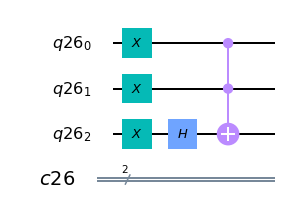

Oracle unitary matrix vector:

[[ 0.          0.          0.          0.70710678  0.          0.
   0.          0.70710678]
 [ 0.          0.          0.70710678  0.          0.          0.
   0.70710678  0.        ]
 [ 0.          0.70710678  0.          0.          0.          0.70710678
   0.          0.        ]
 [-0.70710678  0.          0.          0.          0.70710678  0.
   0.          0.        ]
 [ 0.          0.          0.         -0.70710678  0.          0.
   0.          0.70710678]
 [ 0.          0.         -0.70710678  0.          0.          0.
   0.70710678  0.        ]
 [ 0.         -0.70710678  0.          0.          0.          0.70710678
   0.          0.        ]
 [ 0.70710678  0.          0.          0.          0.70710678  0.
   0.          0.        ]]


In [108]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
oracleCircuit=QuantumCircuit(qr,cr)


oracle_type="|100>"
oracleCircuit.x(qr[0])
oracleCircuit.x(qr[1])
oracleCircuit.x(qr[2])
oracleCircuit.h(qr[2])
oracleCircuit.ccx(qr[0],qr[1],qr[2])
#oracleCircuit.x(qr[1])
#oracleCircuit.h(qr[2]) 
#oracleCircuit.x(qr[0]) 

display(oracleCircuit.draw(output="mpl"))

# Choose unitary simulator
backend = BasicAer.get_backend('unitary_simulator') 
unit=execute(oracleCircuit, backend).result().get_unitary(oracleCircuit)
print("Oracle unitary matrix vector:\n")
print(unit.real)


We also create an amplifier circuit that is used to boost the phase of the correct solution.

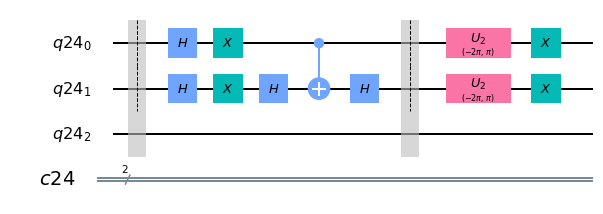

In [104]:
amplifierCircuit=QuantumCircuit(qr,cr)

amplifierCircuit.barrier(qr[0],qr[1])
amplifierCircuit.h(qr[0])
amplifierCircuit.h(qr[1])
amplifierCircuit.x(qr[0])
amplifierCircuit.x(qr[1])
amplifierCircuit.h(qr[1])
amplifierCircuit.cx(qr[0],qr[1])
amplifierCircuit.h(qr[1])
amplifierCircuit.barrier(qr[0],qr[1])
amplifierCircuit.u2(-2*pi,pi, qr[0])
amplifierCircuit.u2(-2*pi,pi, qr[1])
amplifierCircuit.x(qr[0])
amplifierCircuit.x(qr[1])

display(amplifierCircuit.draw(output="mpl"))

Now, let's create the quantum circuit that will enclose our oracle and amplifier, add some measurement gates and give it a whirl.

Grover circuit for: |100>


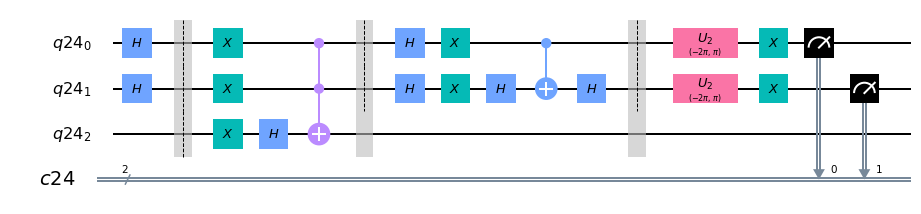

In [105]:
groverCircuit = QuantumCircuit(qr,cr)

# initiate the Grover with Hadamards
groverCircuit.h(qr[0])
groverCircuit.h(qr[1])
groverCircuit.barrier(qr)

# add the oracle and the inversion
groverCircuit+=oracleCircuit
groverCircuit+=amplifierCircuit

# add measurements
groverCircuit.measure(qr[0],cr[0])
groverCircuit.measure(qr[1],cr[1])
print("Grover circuit for:", oracle_type)
groverCircuit.draw(output="mpl")

Finally, let us run the Grover circuit on the qasm simulator to see if it finds the correct solution.

Oracle for:  |100>


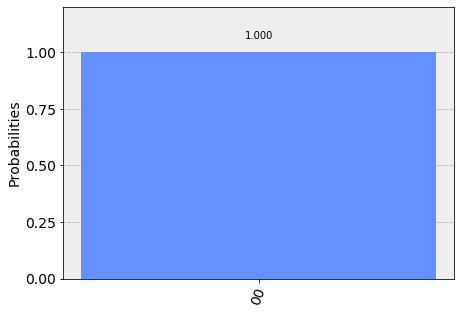

In [106]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
print("Oracle for: ", oracle_type)
display(plot_histogram(answer))

**Now it is your turn!** Modify the code in the oracleCircuit box above to create a different Oracle, such as the other example from above: `|111>`. When you have successfully run that circuit and gotten the expected results, try adding a second set of oracleCircuit and amplifierCircuit to set up two iterations instead of one. Does that make a difference in the end results. How about three iterations?

**For the really curious!** See if you can create the oracleCircuit for the following oracles: `|000>` and `|010>`

# Qiskit Aqua Grover algorithm

Grover comes built-in with Qiskit Aqua. With Aqua you can use two input types to define the oracle: `LogicalExpressionOracle` and `TruthTableOracle`.

An example of a logical expression oracle for the `|001>` oracle above is (with the LSB to the left in the logic):
```
'(A & ~B & ~C)'
```
When you use truth table input you create a bit-string that represents the expected output for the oracle. For the `|001>` example, this bit string is:
```
'01000000'
```

In [29]:
# Do the necessary import for our program
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
from qiskit.compiler import transpile

We can now set the oracle method that we want to use, and then provide the logical expression and bitstring.

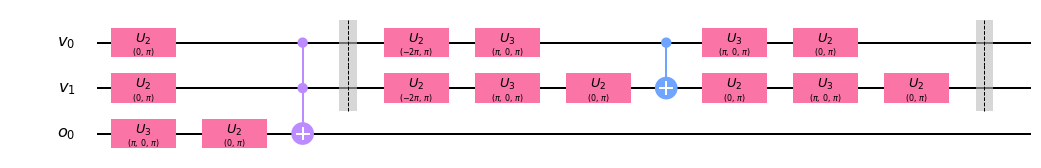

In [30]:
# set the oracle method: "Log" for logical expression or "Bit" for bit string. 
oracle_method = "Log" 

# set the input
log_expr = '(A & B)' #<- Oracle for |001>
bitstr = '0001'  

# build the circuit
if oracle_method=="Log":
    algorithm = Grover(LogicalExpressionOracle(log_expr))
    circuit = Grover(LogicalExpressionOracle(log_expr)).construct_circuit()
else:
    algorithm = Grover(TruthTableOracle(bitstr))
    circuit = Grover(TruthTableOracle(bitstr)).construct_circuit()

circuit.draw(output="mpl")

Oracle for: |100>
Oracle method: Log
11


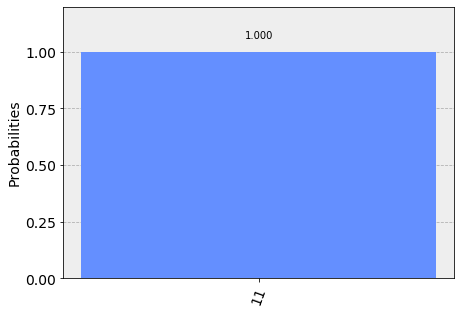

In [31]:
# Run the algorithm on a simulator, printing the most frequently occurring result
backend = BasicAer.get_backend('qasm_simulator')

result = algorithm.run(backend)
print("Oracle for:", oracle_type)
print("Oracle method:",oracle_method)
print(result['top_measurement'])
plot_histogram(result['measurement'])

**Your turn!** Modify the logical expression and/or bitstring to realize the `|111>`, `|000>`, and `|010>` oracles from above. Do they produce the same probabilities as your gate circuit Grover? 

# Taking a look at the Grover circuit, step-by-step

Let's take a look at the behavior of our qubits as we walk through the circuit by viewing the unitary matrix for the oracle and amplifier circuits + the state vector in numeric form and with the Q Sphere.



In [64]:
# Import visualization
from qiskit.visualization import plot_histogram, plot_bloch_multivector, iplot_bloch_multivector, plot_state_qsphere, iplot_state_qsphere

# Add the state vector calculation function
def get_psi(circuit, vis="B"): 
    global psi
    backend = BasicAer.get_backend('statevector_simulator') 
    psi = execute(circuit, backend).result().get_statevector(circuit)
    print("State vector:\n")
    print(psi)
    if vis=="Q":
        display(iplot_state_qsphere(psi))
    elif vis=="q":
        display(plot_state_qsphere(psi))
    elif vis=="M":
        print(psi)
    elif vis=="b":
        display(plot_state_qsphere(psi))
    else: # vis="B"
        display(iplot_bloch_multivector(psi))
    
    vis=""

## Step 1: Create the circuit

Here we create the sircuit and prepare the qubits in a superposition state. The state vector and Q Sphere representions shows us eight possible outcomes with equal probability, as expected.

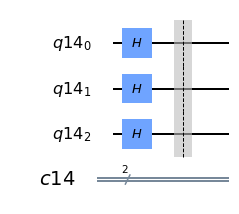

State vector:

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


None

In [65]:
groverVisCircuit = QuantumCircuit(qr,cr)

# initiate the Grover with Hadamards
groverVisCircuit.h(qr)
groverVisCircuit.barrier(qr)
display(groverVisCircuit.draw(output="mpl"))
get_psi(groverVisCircuit,"Q")

## Step 2: Run the oracle

In this step we run the oracle, which flips the oracle state $\pi$ radians from the other possible states. The flipping is done by the doubly-controlled Z-gate (H+CCX+H in the circuit below). The state vector and Q Sphere shows the opposite phase for the |001> state indicated by a minus sign for the state vector, and a phase colored vector for the Q Sphere. 

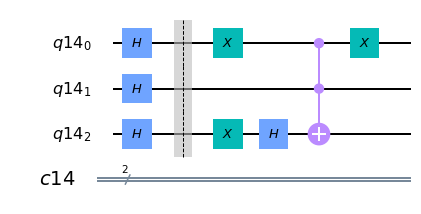

Oracle unitary matrix vector:

[[ 0.70710678  0.          0.          0.          0.70710678  0.
   0.          0.        ]
 [ 0.          0.70710678  0.          0.          0.          0.70710678
   0.          0.        ]
 [ 0.          0.         -0.70710678  0.          0.          0.
   0.70710678  0.        ]
 [ 0.          0.          0.          0.70710678  0.          0.
   0.          0.70710678]
 [-0.70710678  0.          0.          0.          0.70710678  0.
   0.          0.        ]
 [ 0.         -0.70710678  0.          0.          0.          0.70710678
   0.          0.        ]
 [ 0.          0.          0.70710678  0.          0.          0.
   0.70710678  0.        ]
 [ 0.          0.          0.         -0.70710678  0.          0.
   0.          0.70710678]]
State vector:

[0.5+0.j 0.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j]


None

In [66]:
# add the oracle
groverVisCircuit+=oracleCircuit

display(groverVisCircuit.draw(output="mpl"))

# Choose unitary simulator
backend = BasicAer.get_backend('unitary_simulator') 
unit=execute(oracleCircuit, backend).result().get_unitary(oracleCircuit)
print("Oracle unitary matrix vector:\n")
print(unit.real)

get_psi(groverVisCircuit,"Q")

## Step 3: Phase amplification

Finally, we run the qubits through the phase amplification, where the prepared state is again amplified.

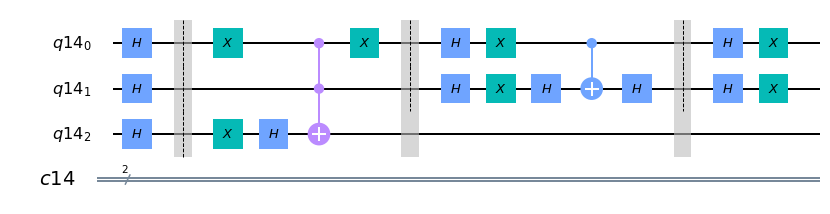

Amplifier unitary matrix vector:

[[-0.5 -0.5 -0.5  0.5  0.   0.   0.   0. ]
 [ 0.5  0.5 -0.5  0.5  0.   0.   0.   0. ]
 [ 0.5 -0.5  0.5  0.5  0.   0.   0.   0. ]
 [ 0.5 -0.5 -0.5 -0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5 -0.5 -0.5  0.5]
 [ 0.   0.   0.   0.   0.5  0.5 -0.5  0.5]
 [ 0.   0.   0.   0.   0.5 -0.5  0.5  0.5]
 [ 0.   0.   0.   0.   0.5 -0.5 -0.5 -0.5]]
State vector:

[-0.25+0.j  0.75+0.j  0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j  0.25+0.j
 -0.25+0.j]


None

In [67]:
# add the inversion
groverVisCircuit+=amplifierCircuit
display(groverVisCircuit.draw(output="mpl"))

# Choose unitary simulator
backend = BasicAer.get_backend('unitary_simulator') 
unit_amp=execute(amplifierCircuit, backend).result().get_unitary(amplifierCircuit)
print("Amplifier unitary matrix vector:\n")
print(unit_amp.real)

get_psi(groverVisCircuit,"Q")

## Bonus exercise: Run the oracle on a real quantum computer

Use your knowledge from the previous exercises to modify the execution steps in this exercise to run on an actual IBM Q backend.